# Imports

In [1]:
import os
import time
import pickle
import numpy as np
from importlib import reload
import ProbeCavityEigenfields as PCE
from common.baseclasses import AWA
from common import plotting
from common import numerical_recipes as numrec
from matplotlib import pyplot as plt

<plotting>:
	Registered colormaps "Warm" and "Warm_r"...
<plotting>:
	Registered colormaps "vanheum" and "vanheum_r"...
<plotting>:
	Registered colormaps "NT-MDT" and "NT-MDT_r"...
<plotting>:
	Registered colormaps "rainbow" and "rainbow_r"...
<plotting>:
	Registered colormaps "jingdi" and "jingdi_r"...
<plotting>:
	Registered colormaps "Halcyon" and "Halcyon_r"...
<plotting>:
	Registered colormaps "Cold" and "Cold_r"...
<plotting>:
	Registered colormaps "Sky" and "Sky_r"...
<plotting>:
	Registered colormaps "Gwyddion.net" and "Gwyddion.net_r"...
<plotting>:
	Registered colormaps "BlueRed" and "BlueRed_r"...
<plotting>:
	Registered colormaps "vanheum3" and "vanheum3_r"...
<plotting>:
	Registered colormaps "vanheum2" and "vanheum2_r"...


# Prepare PCE Model

## Build Probe

In [17]:
#-- Geometric definitions - explicit lengths in nanometers

a_nm=20
taper_angle=17
Rtop=0
WL_THz_nm=300e3 #300 microns = 1 THz

#-- Geometric definitions - relative to probe radius

L=19e3/a_nm
freq_THz=a_nm/WL_THz_nm
freq0=27*freq_THz
gap0=0.1

#-- Build probe

Nsubnodes=2
P=PCE.Probe(Nnodes=244,Nsubnodes=Nsubnodes,L=L,quadrature=numrec.TS,\
                 a=1,taper_angle=taper_angle,geometry='hyperboloid',Rtop=Rtop,
            freq=freq0,gap=gap0,closed=False)

#-- probe attributes

zsprobe=P.get_zs()
rsprobe=P.get_radii()
k=P.get_k()

<__init__.get_probe_radii>:
	Getting geometry for selection "hyperboloid"...
<RotationalMoM.Discretization.__init__>:
	Discretizing body of revolution over 242 annular nodes and 2 subnodes...


/Users/alexandersmcleod/tools/python/common/numerical_recipes.py:266: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if quadrature is TS: weights*=3.85129641897025/numpy.float(len(weights))


(0.0, 3.0)

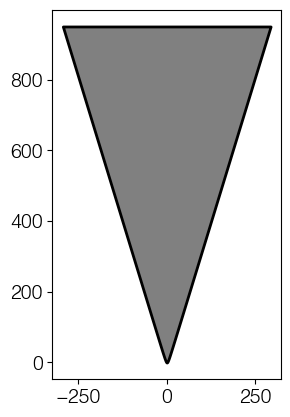

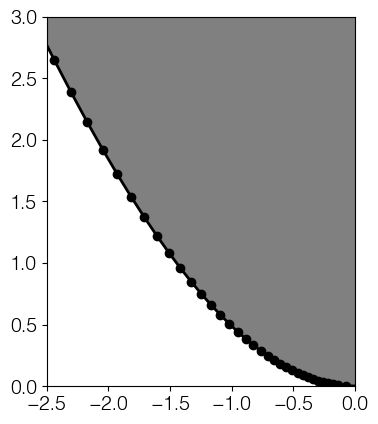

In [18]:
#-- Plot probe shape

plt.figure()
#plt.plot(-radii,zs,radii,zs,color='b')
xsprobe=np.append(-rsprobe[::-1],rsprobe)
ysprobe=np.append(zsprobe[::-1],zsprobe)
plt.fill_between(x=xsprobe,
                 y1=ysprobe,y2=L,
                 color='gray',edgecolor='k',lw=2)
plt.gca().set_aspect('equal')

plt.figure()
#plt.plot(-radii,zs,radii,zs,color='b')
rsprobe = P.Discretization.node_terminal_Rs
zsprobe = P.Discretization.node_terminal_zs
xsprobe=np.append(-rsprobe[::-1],rsprobe)
ysprobe=np.append(zsprobe[::-1],zsprobe)
plt.fill_between(x=xsprobe,
                 y1=ysprobe,y2=L,
                 color='gray',edgecolor='k',lw=2)
plt.plot(xsprobe,ysprobe,marker='o',ls='',color='k')
plt.gca().set_aspect('equal')
plt.xlim(-2.5,0)
plt.ylim(0,3)

<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..


"\nr0=P.get_eigenrhos()[:10]\nr=GapSpectroscopy.get_eigenrhos_AWA().cslice[:10,gap]\nr=AWA(sorted(r,key=lambda r: np.abs(r)))\ndr=(r-r0)\ndr.real.plot(alpha=.3,color='r',lw=10)\ndr.imag.plot(alpha=.3,color='b',lw=10)\nprint(np.abs(dr).max())"

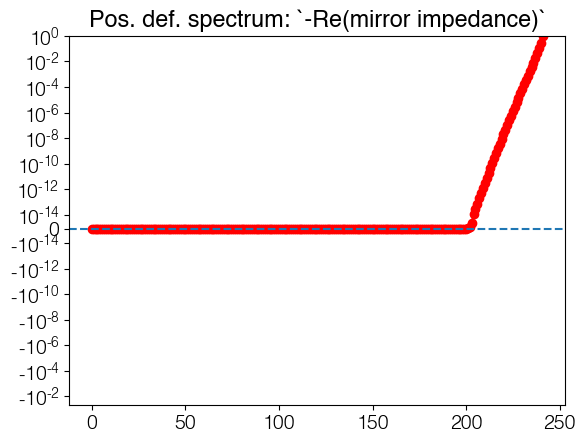

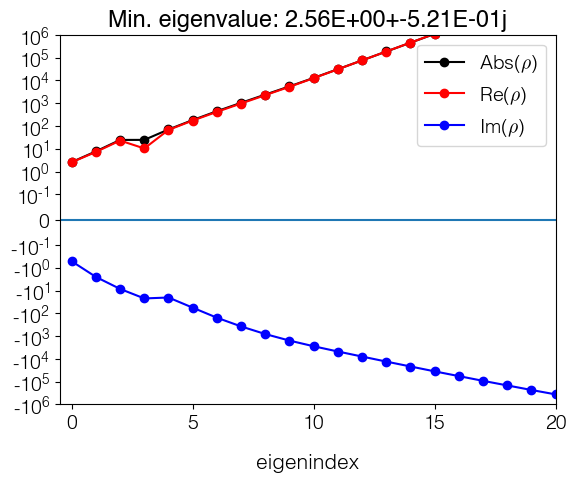

In [24]:
gap=1
P.set_gap(gap)
P.get_mirror_impedance(sommerfeld=True,k=0,recompute=True,
                       Nkappas=244*4,kappa_max=10,kappa_min=None,qquadrature=numrec.GL)
#P.get_mirror_impedance(sommerfeld=False,k=0,recompute=True)
#P.get_self_impedance(recompute=True)
P.solve_eigenmodes(plot=True,condition_ZS=False,condition_ZM=True)
P.plot_eigenrhos()

"""
r0=P.get_eigenrhos()[:10]
r=GapSpectroscopy.get_eigenrhos_AWA().cslice[:10,gap]
r=AWA(sorted(r,key=lambda r: np.abs(r)))
dr=(r-r0)
dr.real.plot(alpha=.3,color='r',lw=10)
dr.imag.plot(alpha=.3,color='b',lw=10)
print(np.abs(dr).max())"""

Computing eigenbrightness...


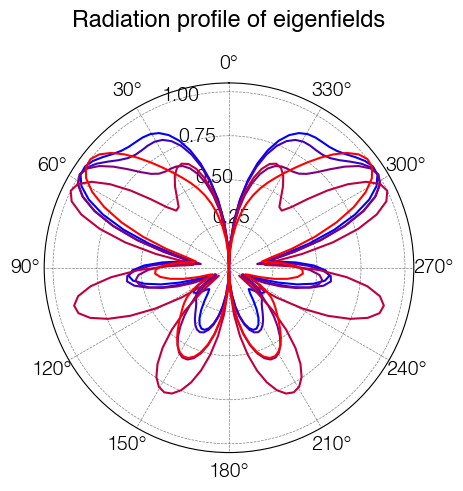

In [5]:
brightnesses=P.get_eigenbrightness(k=None, angles=np.linspace(0, 180, 60), \
                            illumination=PCE.EBesselBeamFF, average=False, \
                            recompute=True)

N=5
cs = plotting.bluered_colors(N)

fig=plt.figure()
ax=fig.add_subplot(111,projection='polar')
for eigenindex in range(N):
    c=next(cs)
    B = np.abs(brightnesses).cslice[:,eigenindex]
    B /= B.max()
    l,=plt.polar(np.deg2rad(B.axes[0]),B,color=c)
    plt.polar(-np.deg2rad(B.axes[0]),B,color=c)

ax.set_theta_zero_location("N")
plt.xticks(np.deg2rad(np.arange(0,360,30)))
plt.title('Radiation profile of eigenfields',pad=20)
ax.set_rticks([0.25,.5,.75, 1])
g=ax.grid(True,ls='--',alpha=.5,color='k')

## Probe spectroscopy

In [6]:
from ProbeCavityEigenfields import ProbeSpectroscopy as PS
from common import misc

#--- Define function that will run our spectroscopy
# Make it auto-pickling so that subsequent `get..` calls reload rather than recompute the result

gaps = np.logspace(-1.5,2,400)

@misc.autopickle('ProbeGapSpectroscopy_taper=%i.pickle'%taper_angle)
def getGapSpectroscopy(P, gaps=gaps, Nmodes=30):
    
    P.set_freq(freq0)
    print('Computing at frequency =',freq0)
    #Don't supply explicit quadrature object, or it will have to be pickled for parallel dispatch
    GS = P.gapSpectroscopy(gaps,recompute=True,Nmodes=20,sommerfeld=True,\
                           Nkappas=244*4,qquadrature='GL')
    #GS = P.gapSpectroscopy(gaps,recompute=True,sommerfeld=False)
    #GS.classify_eigensets(reversed=True,Nmodes=Nmodes) #This happens automatically
    
    return GS

@misc.autopickle('ProbeEncoding_taper=%i.pickle'%taper_angle)
def getProbeEncoding(gap0=1,Nmodes=20,Nkappas=244*8,kappa_max=4*np.pi*10,kappa_min=None,):

    enc = PS.EncodedEigenfields(GapSpectroscopy,gap0=gap0,Nmodes=Nmodes,\
                                Nkappas=Nkappas,kappa_max=kappa_max,kappa_min=kappa_min)
    
    return enc

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigenrhos_AWA>:
	For Nmodes=20, there were 377 identifiable mutual coordinates.


Text(0.5, 0, 'Gap')

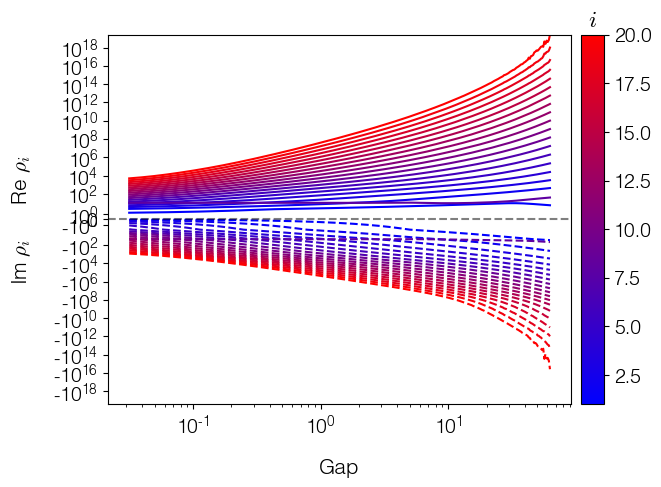

In [28]:
GapSpectroscopy = getGapSpectroscopy(P,recompute=False,overwrite=True,reload=True)
GapSpectroscopy.plot_eigenrhos(Nmodes=30)
plt.gcf().axes[0].set_xlabel('Gap')

In [31]:
#Encoding = getProbeEncoding(gap0=1,Nmodes=20,Nkappas=244*8,kappa_max=4*np.pi*2,
#                           recompute=True,reload=True,save=False)
Encoding = getProbeEncoding(gap0=1,Nmodes=15,Nkappas=244*4,kappa_max=np.inf,kappa_min=None,
                           recompute=True,reload=True,save=False,overwrite=True)

<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_eigencharges_AWA>:
	Obtaining eigencharges for Nmodes=15, across  400 mutual spectroscopy coordinates.
	Aligning eigencharge signage...
<ProbeSpectroscopy.EncodedEigenfields.__init__>:
	Encoding eigenfields to gap=1 across 400 gap values from gap=0.032 to 1e+02...
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.00E+00...
	Updating eigencharges...
	Updating self impedance...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_brightnesses_AWA>:
	Computing brightnesses across 400 spectroscopy coordinates...


# Diagnostics on SiC

## Uniform settings

In [39]:
gapmin=.15
amplitude_nm=50
a_nm=35
amplitude = amplitude_nm / a_nm

freqs_wn = np.linspace(800,1000,50)
freqs = freqs_wn * (a_nm*1e-7)

freqs2_wn = np.linspace(800,1000,20) #less expensive
freqs2 = freqs2_wn * (a_nm*1e-7)

#Reset brightnesses
P.set_freq(freq0)
illum_angles = np.linspace(45, 90, 20)
brightnesses=P.get_eigenbrightness(k=None, angles=illum_angles, \
                            illumination=PCE.EBesselBeamFF, average=True, \
                            recompute=True)


from NearFieldOptics import Materials as M
def rp(freq,q):
    global q_used
    q_used = q
    return M.SiC_6H.reflection_p(freq/(a_nm*1e-7),\
                                              q/(a_nm*1e-7))

Computing eigenbrightness...


0.0018000000000000002
<ProbeSpectroscopy.ProbeGapSpectroscopyParallel.get_probe_at_coord>:
	Updating eigenrhos to coordinate 1.00E+00...
	Updating eigencharges...
	Updating self impedance...
0.0018000000000000002


Text(0.5, 1.0, 'Abs(Brightness)')

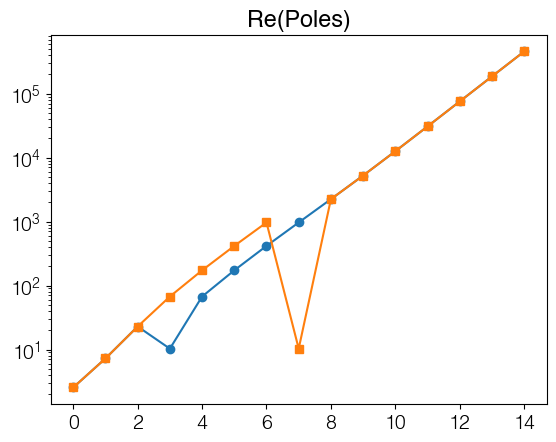

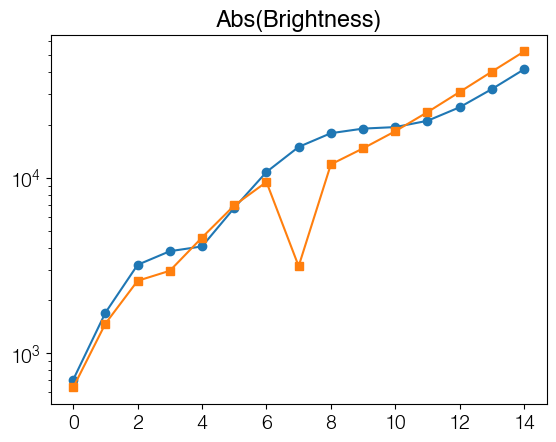

In [40]:
print(P.get_freq())
print(GapSpectroscopy.get_probe_at_coord(1).get_freq())

plt.figure() #The eigenindex of poles may have been resorted by spectroscopy
plt.semilogy(P.get_eigenrhos()[:15].real,marker='o',label='Direct')
plt.semilogy(Encoding.Poles.cslice[1,:15].real,marker='s',label='Encoded')
plt.title('Re(Poles)')

plt.figure()
plt.semilogy(np.abs(P.get_eigenbrightness()[:15]),marker='o',label='Direct')
plt.semilogy(np.abs(Encoding.Brightnesses.cslice[1,:15]),marker='s',label='Encoded')
plt.title('Abs(Brightness)')

## Encoded calculation - near-field + quasi-static only

In [41]:
from NearFieldOptics import Materials as M
snorm_enc = Encoding.getNormalizedSignal(freqs_wn,rp=M.SiC_6H.reflection_p,
                                        a_nm=a_nm,amplitude_nm=amplitude_nm,demod_order=5,
                                        Ngaps=24*4,gapmin=gapmin,
                                        rp_norm = M.Au.reflection_p,
                                        freqs_wn_norm = None)

/Users/alexandersmcleod/tools/python/common/numerical_recipes.py:209: DeprecationWarning: scipy.ifft is deprecated and will be removed in SciPy 2.0.0, use scipy.fft.ifft instead
  F = np.real(ifft(V, n=None, axis=0))
/Users/alexandersmcleod/tools/python/NearFieldOptics/Materials/material_types.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  else: return numpy.complex(val)


	Computing at freq=2.800E-03...
	Computing at freq=2.814E-03...
	Computing at freq=2.829E-03...
	Computing at freq=2.843E-03...
	Computing at freq=2.857E-03...
	Computing at freq=2.871E-03...
	Computing at freq=2.886E-03...
	Computing at freq=2.900E-03...
	Computing at freq=2.914E-03...
	Computing at freq=2.929E-03...
	Computing at freq=2.943E-03...
	Computing at freq=2.957E-03...
	Computing at freq=2.971E-03...
	Computing at freq=2.986E-03...
	Computing at freq=3.000E-03...
	Computing at freq=3.014E-03...
	Computing at freq=3.029E-03...
	Computing at freq=3.043E-03...
	Computing at freq=3.057E-03...
	Computing at freq=3.071E-03...
	Computing at freq=3.086E-03...
	Computing at freq=3.100E-03...
	Computing at freq=3.114E-03...
	Computing at freq=3.129E-03...
	Computing at freq=3.143E-03...
	Computing at freq=3.157E-03...
	Computing at freq=3.171E-03...
	Computing at freq=3.186E-03...
	Computing at freq=3.200E-03...
	Computing at freq=3.214E-03...
	Computing at freq=3.229E-03...
	Computi

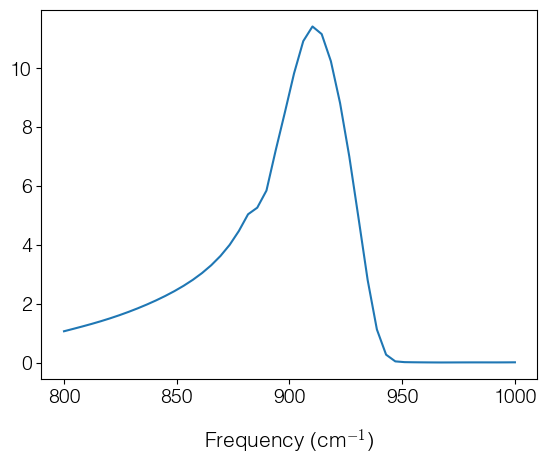

In [42]:
np.abs(snorm_enc['Sn'][3]).plot()

## Direct calculation - near-field + quasi-static only

In [43]:
farfield=False
kwargs=dict(update_brightness=True,zquadrature=numrec.GL,
            Nkappas=244*4,kappa_max=np.inf,kappa_min=None,
            Nmodes=15,farfield=farfield,update_propagators=True,
            illum_angles = illum_angles)
snorm_QS = P.getNormalizedSignal(freqs_wn,rp=M.SiC_6H.reflection_p,
                                        a_nm=a_nm,amplitude_nm=amplitude_nm,demod_order=5,
                                        Ngaps=24,gapmin=gapmin,
                                        rp_norm = M.Au.reflection_p,
                                        freqs_wn_norm = freqs_wn,**kwargs)

"""farfield=False
P._kappa_min_factor=.1
kwargs=dict(update_brightness=False,zquadrature=numrec.GL,Ngaps = 24,
            Nkappas=244*2,kappa_max=np.inf,kappa_min=0,
            Nmodes=15,farfield=farfield) #Note: some of the higher eigenfields are unstable for far-field
signals_ref=P.EradSpectrumDemodulated(freqs=np.mean(freqs),rp=M.Au.reflection_p,
                                            gapmin=gapmin, amplitude=amplitude,
                                            demod_order=5, **kwargs)
signals=P.EradSpectrumDemodulated(freqs=freqs, rp=rp,
                                        gapmin=gapmin, amplitude=amplitude,
                                        demod_order=5, **kwargs)
snorm_QS = signals
snorm_QS['Sn'] /= signals_ref['Sn']
snorm_QS['Sn'].set_axes([None,freqs_wn])
snorm_QS['Erad'].set_axes([None,freqs_wn])"""

Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0028...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..


/Users/alexandersmcleod/tools/python/NearFieldOptics/Materials/material_types.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  else: return numpy.complex(val)


Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002814285714285714...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0028285714285714286...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0028428571428571426...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002857142857142857...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Pro

Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0033142857142857145...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0033285714285714286...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0033428571428571426...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.003357142857142857...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Pr

Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0031000000000000003...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0031142857142857144...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0031285714285714285...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.003142857142857143...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
Computing eigenbrightness...
<__init__.Pr

"farfield=False\nP._kappa_min_factor=.1\nkwargs=dict(update_brightness=False,zquadrature=numrec.GL,Ngaps = 24,\n            Nkappas=244*2,kappa_max=np.inf,kappa_min=0,\n            Nmodes=15,farfield=farfield) #Note: some of the higher eigenfields are unstable for far-field\nsignals_ref=P.EradSpectrumDemodulated(freqs=np.mean(freqs),rp=M.Au.reflection_p,\n                                            gapmin=gapmin, amplitude=amplitude,\n                                            demod_order=5, **kwargs)\nsignals=P.EradSpectrumDemodulated(freqs=freqs, rp=rp,\n                                        gapmin=gapmin, amplitude=amplitude,\n                                        demod_order=5, **kwargs)\nsnorm_QS = signals\nsnorm_QS['Sn'] /= signals_ref['Sn']\nsnorm_QS['Sn'].set_axes([None,freqs_wn])\nsnorm_QS['Erad'].set_axes([None,freqs_wn])"

Text(0.5, 1.0, 'Direct QS result')

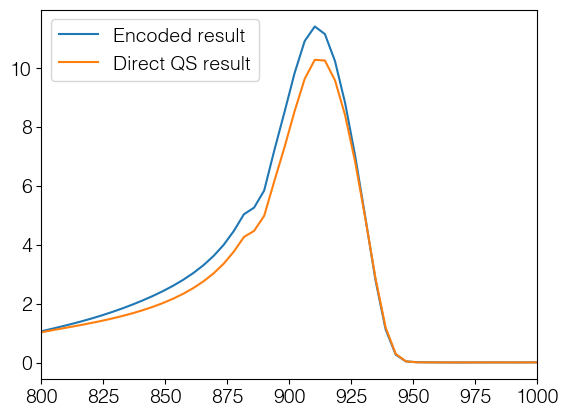

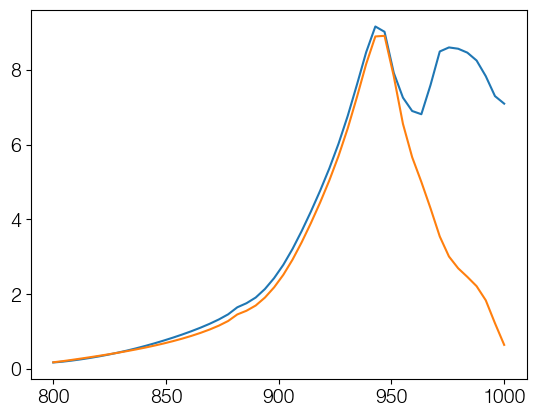

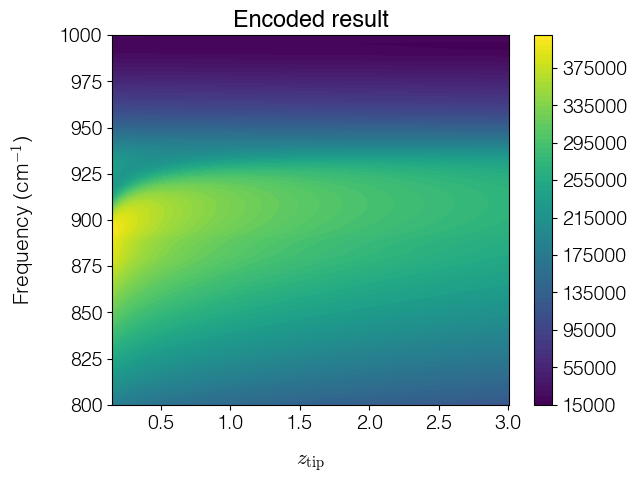

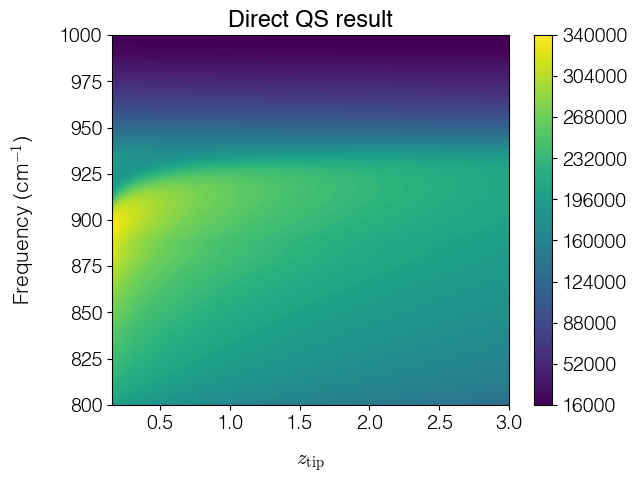

In [44]:
n = 3
plt.plot(freqs_wn,
         np.abs(snorm_enc['Sn'][n]),label='Encoded result')
plt.plot(freqs_wn,
         np.abs(snorm_QS['Sn'][n]),label='Direct QS result')
#plt.ylim(0,15)
plt.xlim(800,1000)
plt.legend()

plt.figure()
plt.plot(freqs_wn,
        np.unwrap(np.angle(snorm_enc['Sn'][n])))
plt.plot(freqs_wn,
        np.unwrap(np.angle(snorm_QS['Sn'][n])))

plt.figure()
np.abs(snorm_enc['Erad']).plot(plotter=plt.contourf)
plt.title('Encoded result')
plt.figure()
np.abs(snorm_QS['Erad']).plot(plotter=plt.contourf)
plt.title('Direct QS result')

## Direct calculation - near-field + far-field all together

In [45]:
farfield=True
kwargs=dict(update_brightness=True,zquadrature=numrec.GL,
            Nkappas=244*4,kappa_max=np.inf,kappa_min=None,
            Nmodes=15,farfield=farfield,update_propagators=True,
            illum_angles = illum_angles)
snorm_FF = P.getNormalizedSignal(freqs_wn,rp=M.SiC_6H.reflection_p,
                                        a_nm=a_nm,amplitude_nm=amplitude_nm,demod_order=5,
                                        Ngaps=24,gapmin=gapmin,
                                        rp_norm = M.Au.reflection_p,
                                        freqs_wn_norm = freqs_wn,**kwargs)

"""farfield=True
P._kappa_min_factor=.1
P._kappa_min_factor=.1
kwargs=dict(update_brightness=False,zquadrature=numrec.GL,Ngaps = 24,
            Nkappas=244*2,kappa_max=np.inf,kappa_min=0,
            Nmodes=15,farfield=farfield) #Note: some of the higher eigenfields are unstable for far-field
signals_ref=P.EradSpectrumDemodulated(freqs=np.mean(freqs),rp=M.Au.reflection_p,
                                            gapmin=gapmin, amplitude=amplitude,
                                            demod_order=5, **kwargs)
signals=P.EradSpectrumDemodulated(freqs=freqs, rp=rp,
                                        gapmin=gapmin, amplitude=amplitude,
                                        demod_order=5, **kwargs)
snorm_FF = signals
snorm_FF['Sn'] /= signals_ref['Sn']
snorm_FF['Sn'].set_axes([None,freqs_wn])
snorm_FF['Erad'].set_axes([None,freqs_wn])"""

Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0028...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..


/Users/alexandersmcleod/tools/python/NearFieldOptics/Materials/material_types.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  else: return numpy.complex(val)


Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002814285714285714...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0028285714285714286...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0028428571428571426...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002857142857142857...
<__init__.Probe.getFourPotentialPr

	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.003242857142857143...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.003257142857142857...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.003271428571428572...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.003285714285714

	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002942857142857143...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.002957142857142857...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0029714285714285715...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00298571428571

Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.003357142857142857...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0033714285714285712...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0033857142857142857...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..
Computing eigenbrightness...
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.0034...
<__init__.Probe.getFourPotentialPropagators>:
	C

"farfield=True\nP._kappa_min_factor=.1\nP._kappa_min_factor=.1\nkwargs=dict(update_brightness=False,zquadrature=numrec.GL,Ngaps = 24,\n            Nkappas=244*2,kappa_max=np.inf,kappa_min=0,\n            Nmodes=15,farfield=farfield) #Note: some of the higher eigenfields are unstable for far-field\nsignals_ref=P.EradSpectrumDemodulated(freqs=np.mean(freqs),rp=M.Au.reflection_p,\n                                            gapmin=gapmin, amplitude=amplitude,\n                                            demod_order=5, **kwargs)\nsignals=P.EradSpectrumDemodulated(freqs=freqs, rp=rp,\n                                        gapmin=gapmin, amplitude=amplitude,\n                                        demod_order=5, **kwargs)\nsnorm_FF = signals\nsnorm_FF['Sn'] /= signals_ref['Sn']\nsnorm_FF['Sn'].set_axes([None,freqs_wn])\nsnorm_FF['Erad'].set_axes([None,freqs_wn])"

Text(0.5, 1.0, 'Direct FF result')

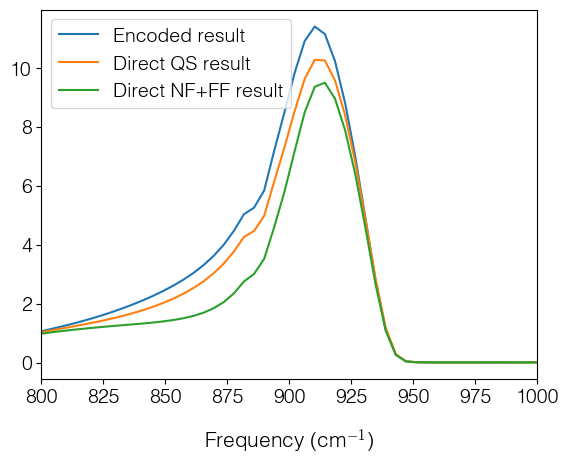

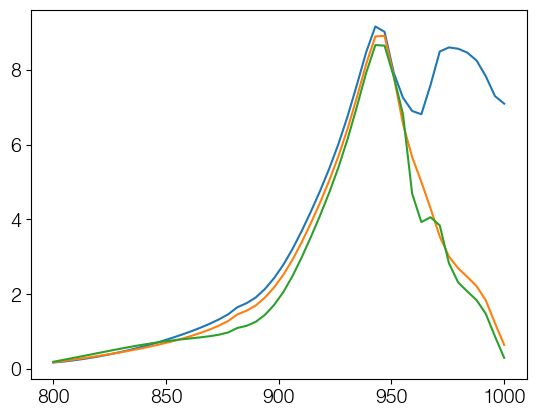

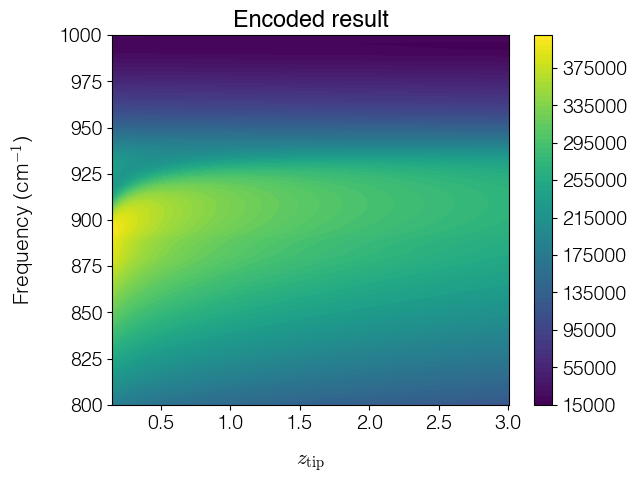

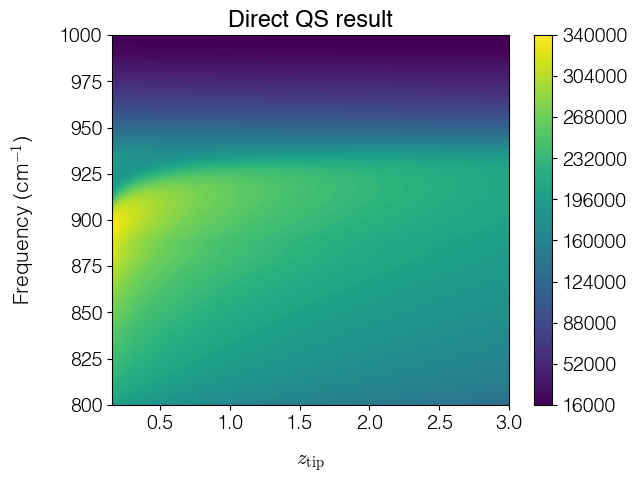

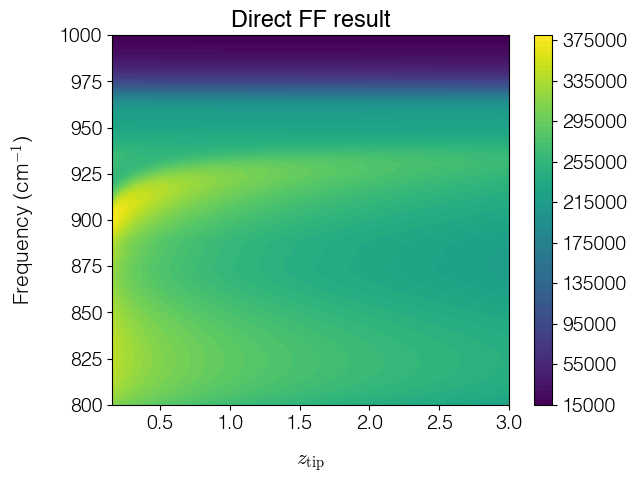

In [46]:
n = 3
np.abs(snorm_enc['Sn'][n]).plot(label='Encoded result')
np.abs(snorm_QS['Sn'][n]).plot(label='Direct QS result')
np.abs(snorm_FF['Sn'][n]).plot(label='Direct NF+FF result')
#plt.ylim(0,15)
plt.xlim(800,1000)
plt.legend()

plt.figure()
plt.plot(snorm_enc['Sn'][n].axes[0],
        np.unwrap(np.angle(snorm_enc['Sn'][n])))
plt.plot(snorm_QS['Sn'][n].axes[0],
        np.unwrap(np.angle(snorm_QS['Sn'][n])))
plt.plot(snorm_FF['Sn'][n].axes[0],
        np.unwrap(np.angle(snorm_FF['Sn'][n])))

plt.figure()
np.abs(snorm_enc['Erad']).plot(plotter=plt.contourf)
plt.title('Encoded result')
plt.figure()
np.abs(snorm_QS['Erad']).plot(plotter=plt.contourf)
plt.title('Direct QS result')
plt.figure()
np.abs(snorm_FF['Erad']).plot(plotter=plt.contourf)
plt.title('Direct FF result')

### Examine q-values used in FF-calculation

In [16]:
#qs=np.ravel([rpvals.axes[0] for rpvals in P.all_rp_vals])
Qs = np.linspace(0,10,100000)

myrps = [rpvals.interpolate_axis(Qs,axis=0,bounds_error=False,extrapolate=True) 
         for rpvals in P.all_rp_vals]
myrps = AWA(myrps, axes=[snorm_FF['Sn'][n].axes[0],Qs], axis_names=['Frequency (cm-1)','Q (cm-1)'])

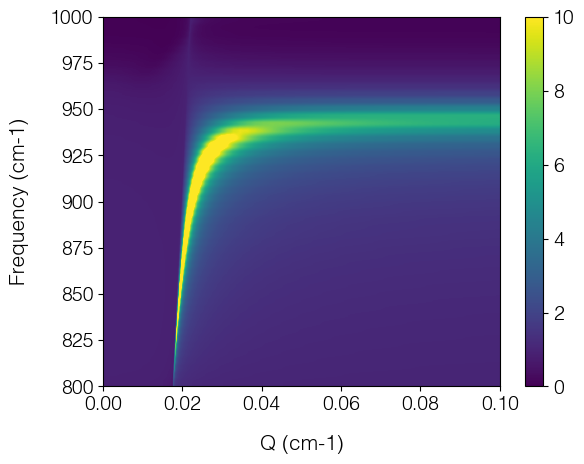

In [17]:
np.abs(myrps).T.plot()
plt.xlim(0,.1)
plt.clim(0,10)

(0.0, 0.05)

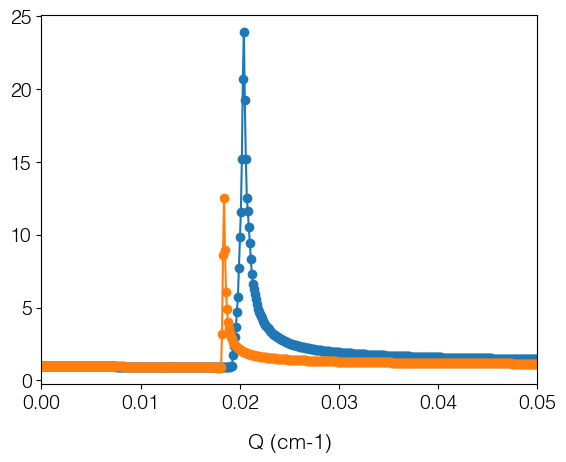

In [18]:
np.abs(myrps).cslice[875].plot(marker='o')
plt.xlim(0,.05)
np.abs(myrps).cslice[825].plot(marker='o')
plt.xlim(0,.05)

## Examine converge w.r.t. Nmodes

### Direct calculation - near-field + quasi-static only

In [19]:
freq_wn = 880
freq = freq_wn*a_nm*1e-7

Erads=[]
recompute_propagators=True
all_Nmodes=np.arange(5,21,1)

farfield=False
kwargs=dict(recompute_brightness=False,zquadrature=numrec.GL,Nzs = 24,
            Nkappas=244*2,kappa_max=10,kappa_min=0,
            farfield=farfield)
for Nmodes in all_Nmodes:
    print(Nmodes)
    erad=P.EradVsGap(freq, zmin=.1, zmax=4, \
                      Nmodes=Nmodes, 
                      rp=rp, recompute_rp=True, \
                      recompute_propagators=recompute_propagators, \
                      subtract_background=True, \
                      illumination=PCE.EBesselBeamFF, **kwargs)
    Erads.append(erad['Erad'])
    recompute_propagators=False
    
Erads = AWA(Erads,axes=[all_Nmodes]+Erads[0].axes,
           axis_names=['N modes']+Erads[0].axis_names)

5
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..


/Users/alexandersmcleod/tools/python/NearFieldOptics/Materials/material_types.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  else: return numpy.complex(val)
/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/__init__.py:1091: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Erad = np.complex(Vn.T @ (self.Scat

6
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
7
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
8
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
9
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
10
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
11
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
12
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
13
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
14
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
15
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
16
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
17
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
18
<__init__.Probe.EradVsGap>:
	Computing response for g

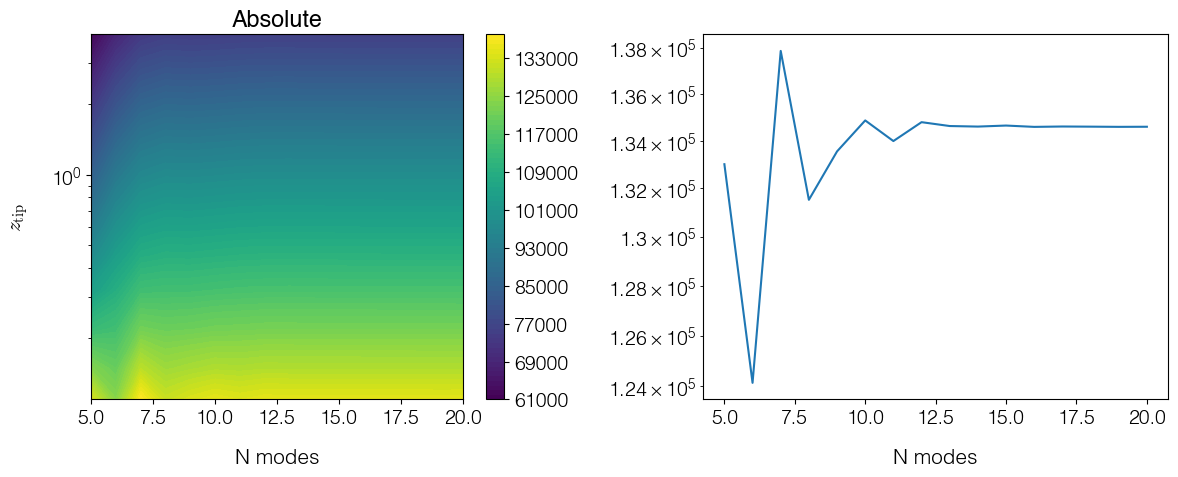

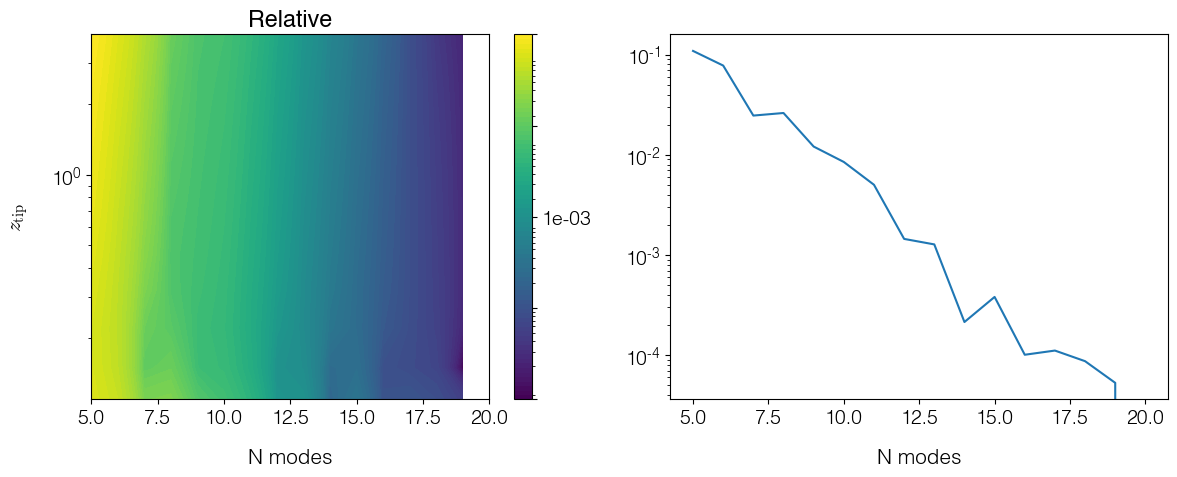

In [20]:

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Absolute')
np.abs(Erads).plot(plotter=plt.contourf)
plt.gca().set_yscale('log')

plt.subplot(122)
np.abs(Erads).cslice[:,.1].plot(plotter=plt.semilogy)
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Relative')
diffnorm = (Erads-Erads[-1])/Erads[-1]
np.abs(diffnorm).plot(plotter=plt.contourf,log_scale=True)
plt.gca().set_yscale('log')
#plt.clim(1e-3,10)

plt.subplot(122)
np.abs(diffnorm).cslice[:,.1].plot(plotter=plt.semilogy)
plt.tight_layout()

### Direct calculation - near-field + far-field all together

In [21]:
freq_wn = 880
freq = freq_wn*a_nm*1e-7

Erads=[]
recompute_propagators=True
all_Nmodes=np.arange(5,21,1)

farfield=True
kwargs=dict(recompute_brightness=False,zquadrature=numrec.GL,Nzs = 24,
            Nkappas=244*2,kappa_max=10,kappa_min=0,
            farfield=farfield) 
for Nmodes in all_Nmodes:
    print(Nmodes)
    erad=P.EradVsGap(freq, zmin=.1, zmax=4, \
                      Nmodes=Nmodes, 
                      rp=rp, recompute_rp=True, \
                      recompute_propagators=recompute_propagators, \
                      subtract_background=True, \
                      illumination=PCE.EBesselBeamFF, **kwargs)
    Erads.append(erad['Erad'])
    recompute_propagators=False
    
Erads = AWA(Erads,axes=[all_Nmodes]+Erads[0].axes,
           axis_names=['N modes']+Erads[0].axis_names)

5
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
<__init__.Probe.getFourPotentialPropagators>:
	Computing field propagators...
	Including evanescent (near-field) waves..
	Including propogating (far-field) waves..


/Users/alexandersmcleod/tools/python/NearFieldOptics/Materials/material_types.py:29: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  else: return numpy.complex(val)
/Users/alexandersmcleod/tools/python/ProbeCavityEigenfields/__init__.py:1091: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Erad = np.complex(Vn.T @ (self.Scat

6
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
7
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
8
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
9
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
10
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
11
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
12
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
13
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
14
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
15
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
16
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
17
<__init__.Probe.EradVsGap>:
	Computing response for gaps at freq=0.00308...
18
<__init__.Probe.EradVsGap>:
	Computing response for g

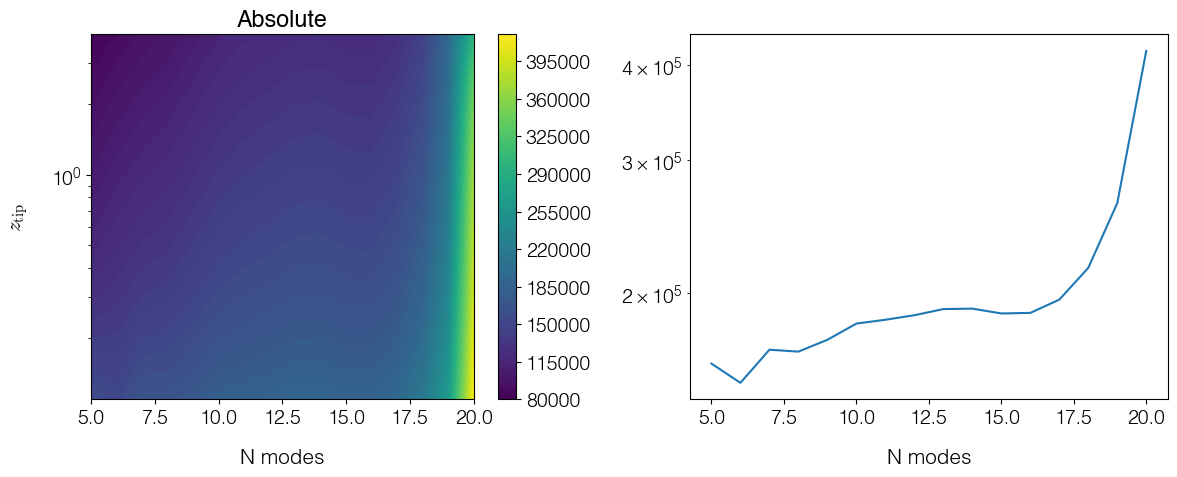

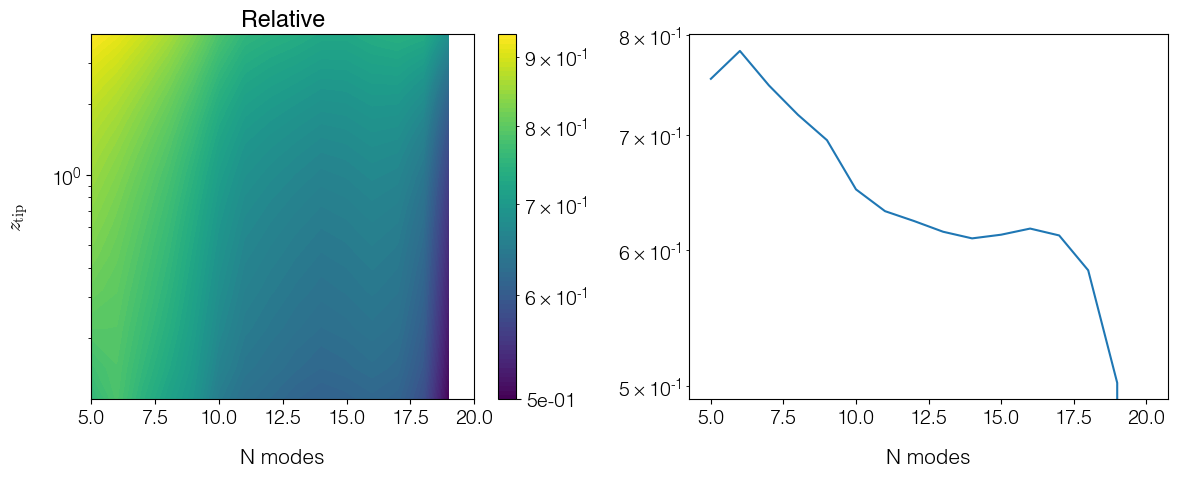

In [22]:

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Absolute')
np.abs(Erads).plot(plotter=plt.contourf)
plt.gca().set_yscale('log')

plt.subplot(122)
np.abs(Erads).cslice[:,.1].plot(plotter=plt.semilogy)
plt.tight_layout()

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Relative')
diffnorm = (Erads-Erads[-1])/Erads[-1]
np.abs(diffnorm).plot(plotter=plt.contourf,log_scale=True)
plt.gca().set_yscale('log')
#plt.clim(1e-3,10)

plt.subplot(122)
np.abs(diffnorm).cslice[:,.1].plot(plotter=plt.semilogy)
plt.tight_layout()